In [ ]:
import os
import random
from datetime import datetime
import ast
import copy

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim.lr_scheduler as lr_scheduler

from preprocessing.final_preprocessing import serve_data, serve_data_sine

from models.transformer_encoder import TransEncoder
from models.baseline import BaseLineModel

from ddpm.ddpm import GaussianDiffusion1D

from evaluation.pca_tsne import visual_evaluation
from evaluation.jsd import plot_jsd
from evaluation.rmse import rmse

gc.collect()

random.seed(42)
np.random.seed(42)

In [3]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Parameters

In [4]:
config_path = "./config_baseline.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = 5*16**-4
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine or TransEncoder"
assert cond_model in {"mlp", "te", "fft", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te, fft and stft"

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"

# Data

In [6]:
# train_loader, test_loader, features , test_data = serve_data_sine(batch_size_config, seq_len, var=1000)
# cond_features = 10

In [7]:
train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data(types=["re"],seq_len=seq_len, batch_size=batch_size_config)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


(13129, 10, 12)


# Model

In [8]:
model = BaseLineModel(seq_len=seq_len, hidden_dim=latent_dim, cond_dim=cond_features, cond_model=cond_model, device=device, channels=features)

ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr)
scheduler = lr_scheduler.StepLR(optim, step_size=1000, gamma=0.9)

writer = SummaryWriter(tb_writer)

## Train

In [9]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

rmse_list = []
lowest_loss = 100000
step=0

for running_epoch in tqdm(range(epochs)):
    running_loss = 0.0
    
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
                
        batch_size = data.shape[0]
        
        optim.zero_grad()
        
        loss = ddpm(data, None)
        loss.backward()
        
        optim.step()
        scheduler.step()
                
        running_loss += loss.item()

        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = running_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, running_epoch)
    
    if running_epoch % 5 ==0:        
        with torch.no_grad():
            sample = ddpm.sample(batch_size_config)
        
        p = sample.cpu()
        q = torch.from_numpy(test_data[:batch_size_config])
            
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, running_epoch)
        
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse_res:.4f}')
    
    else:
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}')
            
            
    if running_epoch % save_rate == 0:
        torch.save({
            'epoch': running_epoch+1,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'ep_{running_epoch}_mse_{avg_epoch_loss:.3f}_weights.pth'))

torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

  1%|          | 1/100 [00:04<07:52,  4.77s/it]

Epoch: 1, Epoch Loss: 1.1670, RMSE: 0.7859


  2%|▏         | 2/100 [00:05<04:16,  2.62s/it]

Epoch: 2, Epoch Loss: 1.0052


  3%|▎         | 3/100 [00:06<03:07,  1.93s/it]

Epoch: 3, Epoch Loss: 1.0032


  4%|▍         | 4/100 [00:08<02:34,  1.61s/it]

Epoch: 4, Epoch Loss: 1.0026


  5%|▌         | 5/100 [00:09<02:15,  1.43s/it]

Epoch: 5, Epoch Loss: 1.0039


  6%|▌         | 6/100 [00:13<03:47,  2.42s/it]

Epoch: 6, Epoch Loss: 0.9985, RMSE: 0.7835


  7%|▋         | 7/100 [00:14<03:05,  1.99s/it]

Epoch: 7, Epoch Loss: 0.9900


  8%|▊         | 8/100 [00:15<02:37,  1.71s/it]

Epoch: 8, Epoch Loss: 0.9806


  9%|▉         | 9/100 [00:16<02:18,  1.53s/it]

Epoch: 9, Epoch Loss: 0.9778


 10%|█         | 10/100 [00:18<02:05,  1.40s/it]

Epoch: 10, Epoch Loss: 0.9726


 11%|█         | 11/100 [00:22<03:29,  2.36s/it]

Epoch: 11, Epoch Loss: 0.9738, RMSE: 0.7564


 12%|█▏        | 12/100 [00:23<02:54,  1.98s/it]

Epoch: 12, Epoch Loss: 0.9718


 13%|█▎        | 13/100 [00:24<02:29,  1.72s/it]

Epoch: 13, Epoch Loss: 0.9728


 14%|█▍        | 14/100 [00:25<02:12,  1.54s/it]

Epoch: 14, Epoch Loss: 0.9718


 15%|█▌        | 15/100 [00:27<02:00,  1.42s/it]

Epoch: 15, Epoch Loss: 0.9717


 16%|█▌        | 16/100 [00:31<03:10,  2.27s/it]

Epoch: 16, Epoch Loss: 0.9713, RMSE: 0.7540


 17%|█▋        | 17/100 [00:32<02:38,  1.91s/it]

Epoch: 17, Epoch Loss: 0.9716


 18%|█▊        | 18/100 [00:33<02:16,  1.66s/it]

Epoch: 18, Epoch Loss: 0.9690


 19%|█▉        | 19/100 [00:34<02:00,  1.48s/it]

Epoch: 19, Epoch Loss: 0.9687


 20%|██        | 20/100 [00:35<01:49,  1.37s/it]

Epoch: 20, Epoch Loss: 0.9693


 21%|██        | 21/100 [00:40<03:01,  2.29s/it]

Epoch: 21, Epoch Loss: 0.9708, RMSE: 0.7589


 22%|██▏       | 22/100 [00:41<02:31,  1.94s/it]

Epoch: 22, Epoch Loss: 0.9679


 23%|██▎       | 23/100 [00:42<02:10,  1.70s/it]

Epoch: 23, Epoch Loss: 0.9704


 24%|██▍       | 24/100 [00:43<01:55,  1.52s/it]

Epoch: 24, Epoch Loss: 0.9709


 25%|██▌       | 25/100 [00:44<01:45,  1.40s/it]

Epoch: 25, Epoch Loss: 0.9690


 26%|██▌       | 26/100 [00:48<02:49,  2.29s/it]

Epoch: 26, Epoch Loss: 0.9667, RMSE: 0.7606


 27%|██▋       | 27/100 [00:50<02:21,  1.94s/it]

Epoch: 27, Epoch Loss: 0.9693


 28%|██▊       | 28/100 [00:51<02:02,  1.70s/it]

Epoch: 28, Epoch Loss: 0.9690


 29%|██▉       | 29/100 [00:52<01:48,  1.52s/it]

Epoch: 29, Epoch Loss: 0.9674


 30%|███       | 30/100 [00:53<01:38,  1.41s/it]

Epoch: 30, Epoch Loss: 0.9702


 31%|███       | 31/100 [00:57<02:42,  2.35s/it]

Epoch: 31, Epoch Loss: 0.9695, RMSE: 0.7691


 32%|███▏      | 32/100 [00:59<02:14,  1.98s/it]

Epoch: 32, Epoch Loss: 0.9677


 33%|███▎      | 33/100 [01:00<01:55,  1.73s/it]

Epoch: 33, Epoch Loss: 0.9687


 34%|███▍      | 34/100 [01:01<01:42,  1.55s/it]

Epoch: 34, Epoch Loss: 0.9668


 35%|███▌      | 35/100 [01:02<01:32,  1.42s/it]

Epoch: 35, Epoch Loss: 0.9691


 36%|███▌      | 36/100 [01:06<02:27,  2.31s/it]

Epoch: 36, Epoch Loss: 0.9687, RMSE: 0.7671


 37%|███▋      | 37/100 [01:07<02:03,  1.96s/it]

Epoch: 37, Epoch Loss: 0.9678


 38%|███▊      | 38/100 [01:09<01:46,  1.71s/it]

Epoch: 38, Epoch Loss: 0.9646


 39%|███▉      | 39/100 [01:10<01:33,  1.54s/it]

Epoch: 39, Epoch Loss: 0.9598


 40%|████      | 40/100 [01:11<01:24,  1.42s/it]

Epoch: 40, Epoch Loss: 0.9532


 41%|████      | 41/100 [01:15<02:19,  2.36s/it]

Epoch: 41, Epoch Loss: 0.9144, RMSE: 0.7746


 42%|████▏     | 42/100 [01:17<01:55,  1.99s/it]

Epoch: 42, Epoch Loss: 0.8260


 43%|████▎     | 43/100 [01:18<01:38,  1.73s/it]

Epoch: 43, Epoch Loss: 0.6924


 44%|████▍     | 44/100 [01:19<01:27,  1.55s/it]

Epoch: 44, Epoch Loss: 0.5673


 45%|████▌     | 45/100 [01:20<01:18,  1.43s/it]

Epoch: 45, Epoch Loss: 0.4535


 46%|████▌     | 46/100 [01:24<02:05,  2.32s/it]

Epoch: 46, Epoch Loss: 0.4156, RMSE: 0.7277


 47%|████▋     | 47/100 [01:26<01:44,  1.97s/it]

Epoch: 47, Epoch Loss: 0.3935


 48%|████▊     | 48/100 [01:27<01:29,  1.72s/it]

Epoch: 48, Epoch Loss: 0.3793


 49%|████▉     | 49/100 [01:28<01:18,  1.54s/it]

Epoch: 49, Epoch Loss: 0.3721


 50%|█████     | 50/100 [01:29<01:11,  1.42s/it]

Epoch: 50, Epoch Loss: 0.3641


 51%|█████     | 51/100 [01:34<01:56,  2.37s/it]

Epoch: 51, Epoch Loss: 0.3564, RMSE: 0.7449


 52%|█████▏    | 52/100 [01:35<01:36,  2.01s/it]

Epoch: 52, Epoch Loss: 0.3515


 53%|█████▎    | 53/100 [01:36<01:22,  1.75s/it]

Epoch: 53, Epoch Loss: 0.3511


 54%|█████▍    | 54/100 [01:37<01:12,  1.57s/it]

Epoch: 54, Epoch Loss: 0.3486


 55%|█████▌    | 55/100 [01:38<01:04,  1.44s/it]

Epoch: 55, Epoch Loss: 0.3434


 56%|█████▌    | 56/100 [01:43<01:42,  2.33s/it]

Epoch: 56, Epoch Loss: 0.3411, RMSE: 0.7516


 57%|█████▋    | 57/100 [01:44<01:24,  1.97s/it]

Epoch: 57, Epoch Loss: 0.3399


 58%|█████▊    | 58/100 [01:45<01:12,  1.72s/it]

Epoch: 58, Epoch Loss: 0.3347


 59%|█████▉    | 59/100 [01:46<01:03,  1.54s/it]

Epoch: 59, Epoch Loss: 0.3289


 60%|██████    | 60/100 [01:47<00:58,  1.47s/it]

Epoch: 60, Epoch Loss: 0.3275


 61%|██████    | 61/100 [01:52<01:33,  2.41s/it]

Epoch: 61, Epoch Loss: 0.3312, RMSE: 0.7631


 62%|██████▏   | 62/100 [01:53<01:16,  2.02s/it]

Epoch: 62, Epoch Loss: 0.3279


 63%|██████▎   | 63/100 [01:54<01:04,  1.76s/it]

Epoch: 63, Epoch Loss: 0.3245


 64%|██████▍   | 64/100 [01:55<00:56,  1.57s/it]

Epoch: 64, Epoch Loss: 0.3242


 65%|██████▌   | 65/100 [01:56<00:50,  1.44s/it]

Epoch: 65, Epoch Loss: 0.3270


 66%|██████▌   | 66/100 [02:01<01:19,  2.34s/it]

Epoch: 66, Epoch Loss: 0.3234, RMSE: 0.7713


 67%|██████▋   | 67/100 [02:02<01:05,  1.97s/it]

Epoch: 67, Epoch Loss: 0.3239


 68%|██████▊   | 68/100 [02:03<00:55,  1.72s/it]

Epoch: 68, Epoch Loss: 0.3207


 69%|██████▉   | 69/100 [02:04<00:47,  1.55s/it]

Epoch: 69, Epoch Loss: 0.3160


 70%|███████   | 70/100 [02:05<00:42,  1.43s/it]

Epoch: 70, Epoch Loss: 0.3201


 71%|███████   | 71/100 [02:10<01:08,  2.38s/it]

Epoch: 71, Epoch Loss: 0.3180, RMSE: 0.7755


 72%|███████▏  | 72/100 [02:11<00:56,  2.01s/it]

Epoch: 72, Epoch Loss: 0.3143


 73%|███████▎  | 73/100 [02:12<00:47,  1.75s/it]

Epoch: 73, Epoch Loss: 0.3174


 74%|███████▍  | 74/100 [02:13<00:40,  1.56s/it]

Epoch: 74, Epoch Loss: 0.3150


 75%|███████▌  | 75/100 [02:14<00:35,  1.43s/it]

Epoch: 75, Epoch Loss: 0.3052


 76%|███████▌  | 76/100 [02:19<00:55,  2.33s/it]

Epoch: 76, Epoch Loss: 0.3098, RMSE: 0.7590


 77%|███████▋  | 77/100 [02:20<00:45,  1.97s/it]

Epoch: 77, Epoch Loss: 0.3027


 78%|███████▊  | 78/100 [02:21<00:37,  1.72s/it]

Epoch: 78, Epoch Loss: 0.3003


 79%|███████▉  | 79/100 [02:22<00:32,  1.55s/it]

Epoch: 79, Epoch Loss: 0.3010


 80%|████████  | 80/100 [02:23<00:28,  1.42s/it]

Epoch: 80, Epoch Loss: 0.2997


 81%|████████  | 81/100 [02:28<00:45,  2.38s/it]

Epoch: 81, Epoch Loss: 0.3014, RMSE: 0.7480


 82%|████████▏ | 82/100 [02:29<00:36,  2.00s/it]

Epoch: 82, Epoch Loss: 0.2989


 83%|████████▎ | 83/100 [02:30<00:29,  1.74s/it]

Epoch: 83, Epoch Loss: 0.2973


 84%|████████▍ | 84/100 [02:31<00:24,  1.56s/it]

Epoch: 84, Epoch Loss: 0.2924


 85%|████████▌ | 85/100 [02:33<00:21,  1.43s/it]

Epoch: 85, Epoch Loss: 0.2956


 86%|████████▌ | 86/100 [02:37<00:32,  2.35s/it]

Epoch: 86, Epoch Loss: 0.2894, RMSE: 0.7359


 87%|████████▋ | 87/100 [02:38<00:25,  1.99s/it]

Epoch: 87, Epoch Loss: 0.2896


 88%|████████▊ | 88/100 [02:39<00:20,  1.74s/it]

Epoch: 88, Epoch Loss: 0.2919


 89%|████████▉ | 89/100 [02:41<00:17,  1.57s/it]

Epoch: 89, Epoch Loss: 0.2882


 90%|█████████ | 90/100 [02:42<00:14,  1.44s/it]

Epoch: 90, Epoch Loss: 0.2855


 91%|█████████ | 91/100 [02:46<00:21,  2.39s/it]

Epoch: 91, Epoch Loss: 0.2853, RMSE: 0.7396


 92%|█████████▏| 92/100 [02:47<00:16,  2.02s/it]

Epoch: 92, Epoch Loss: 0.2882


 93%|█████████▎| 93/100 [02:49<00:12,  1.75s/it]

Epoch: 93, Epoch Loss: 0.2868


 94%|█████████▍| 94/100 [02:50<00:09,  1.57s/it]

Epoch: 94, Epoch Loss: 0.2867


 95%|█████████▌| 95/100 [02:51<00:07,  1.44s/it]

Epoch: 95, Epoch Loss: 0.2842


 96%|█████████▌| 96/100 [02:55<00:09,  2.31s/it]

Epoch: 96, Epoch Loss: 0.2896, RMSE: 0.7514


 97%|█████████▋| 97/100 [02:56<00:05,  1.95s/it]

Epoch: 97, Epoch Loss: 0.2839


 98%|█████████▊| 98/100 [02:57<00:03,  1.69s/it]

Epoch: 98, Epoch Loss: 0.2847


 99%|█████████▉| 99/100 [02:58<00:01,  1.51s/it]

Epoch: 99, Epoch Loss: 0.2810


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]

Epoch: 100, Epoch Loss: 0.2853


In [10]:
model.load_state_dict(torch.load(os.path.join(f'{run_path}', 'best_model_weights.pth')))
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

C:\Users\Arne\AppData\Local\Temp\ipykernel_26224\1081204139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(f'{run_path}', 

## Sampling

In [11]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 144.89it/s]

Samples shape: (256, 10, 12)


# Evaluation
## Without Conditioning
### Train

In [12]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([256, 10, 12]), torch.Size([256, 10, 12]))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


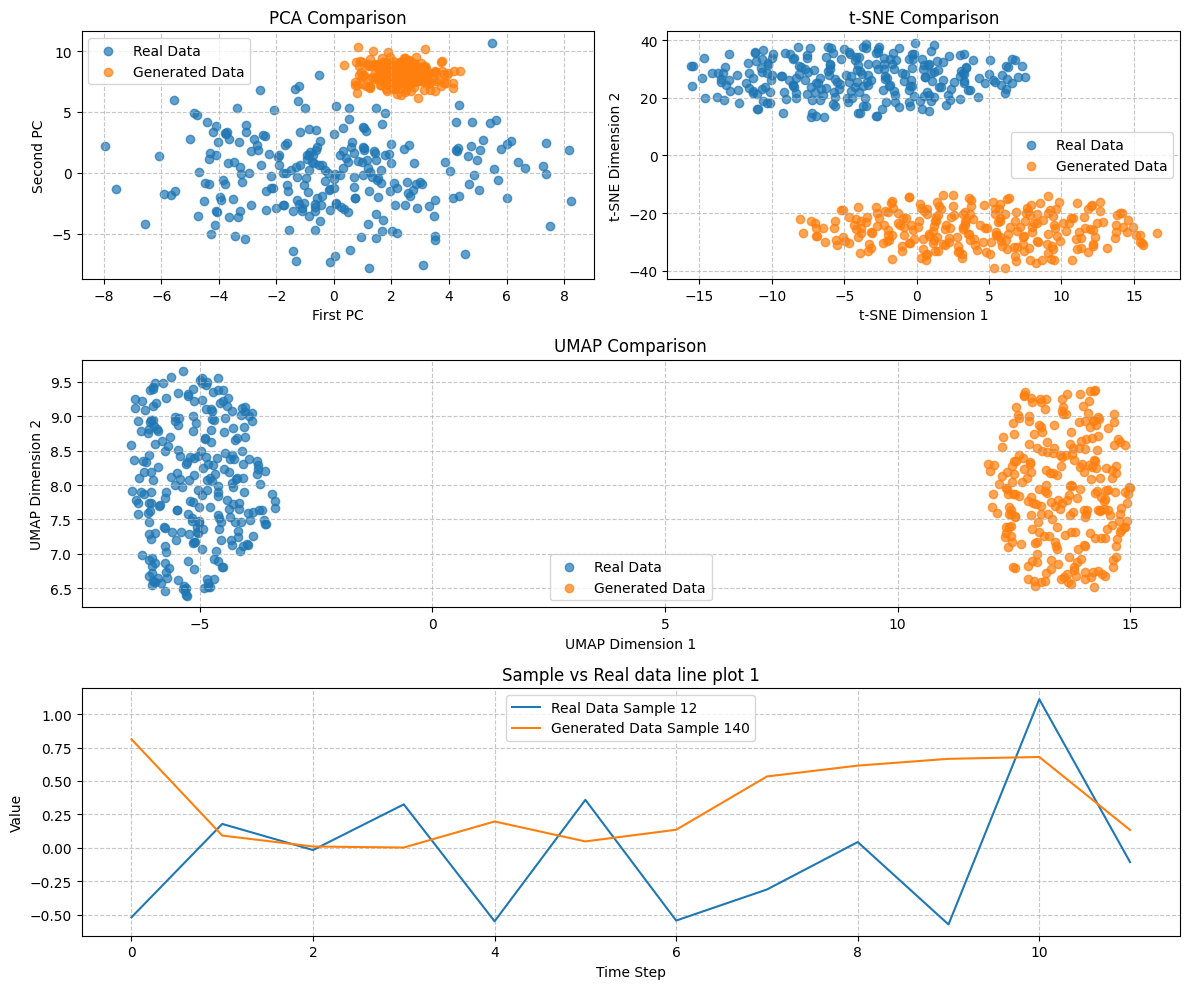

In [13]:
visual_evaluation(real_data_train, samples, log_file_name, False, "train")

### Test

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


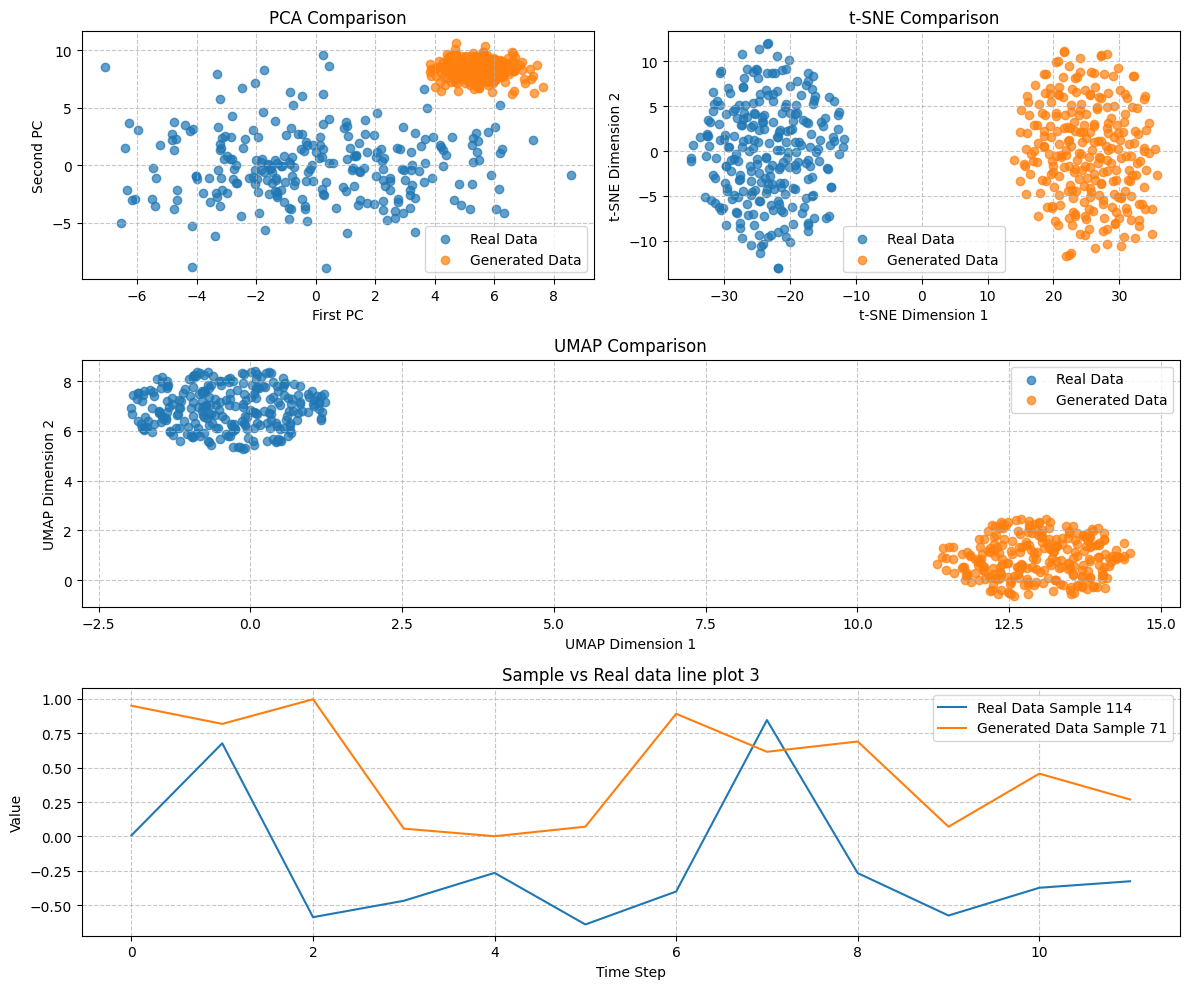

In [14]:
visual_evaluation(real_data_test, samples, log_file_name, False, "test")

### Jensen-Shannon Divergence

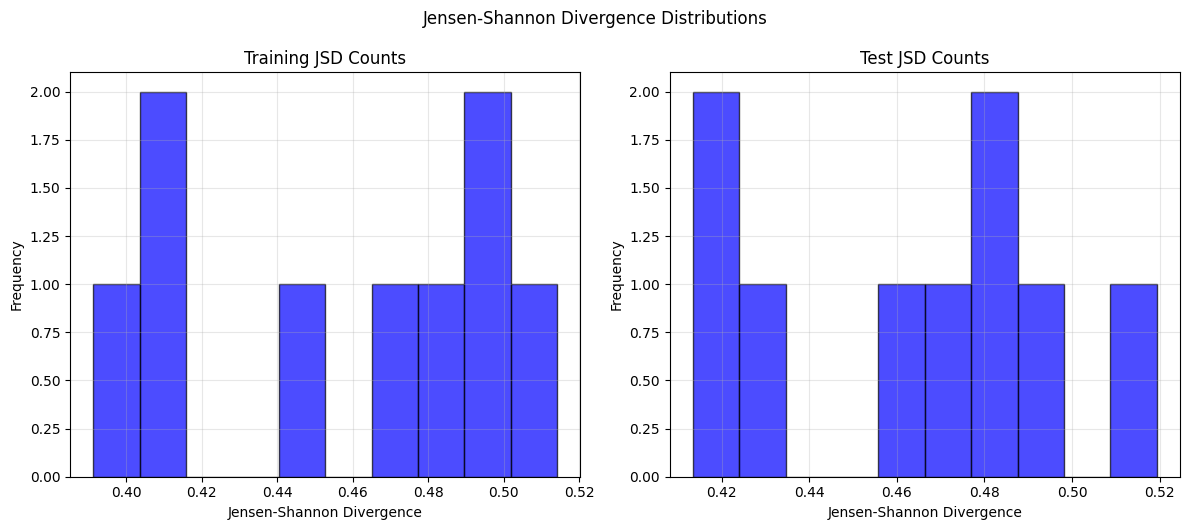

In [15]:
plot_jsd(real_data_train, real_data_test, samples.transpose(0,2,1), log_file_name)

### Plot Comparison

sampling loop time step: 100%|██████████| 500/500 [00:00<00:00, 866.32it/s]


Text(0.5, 1.0, 'Real Data')

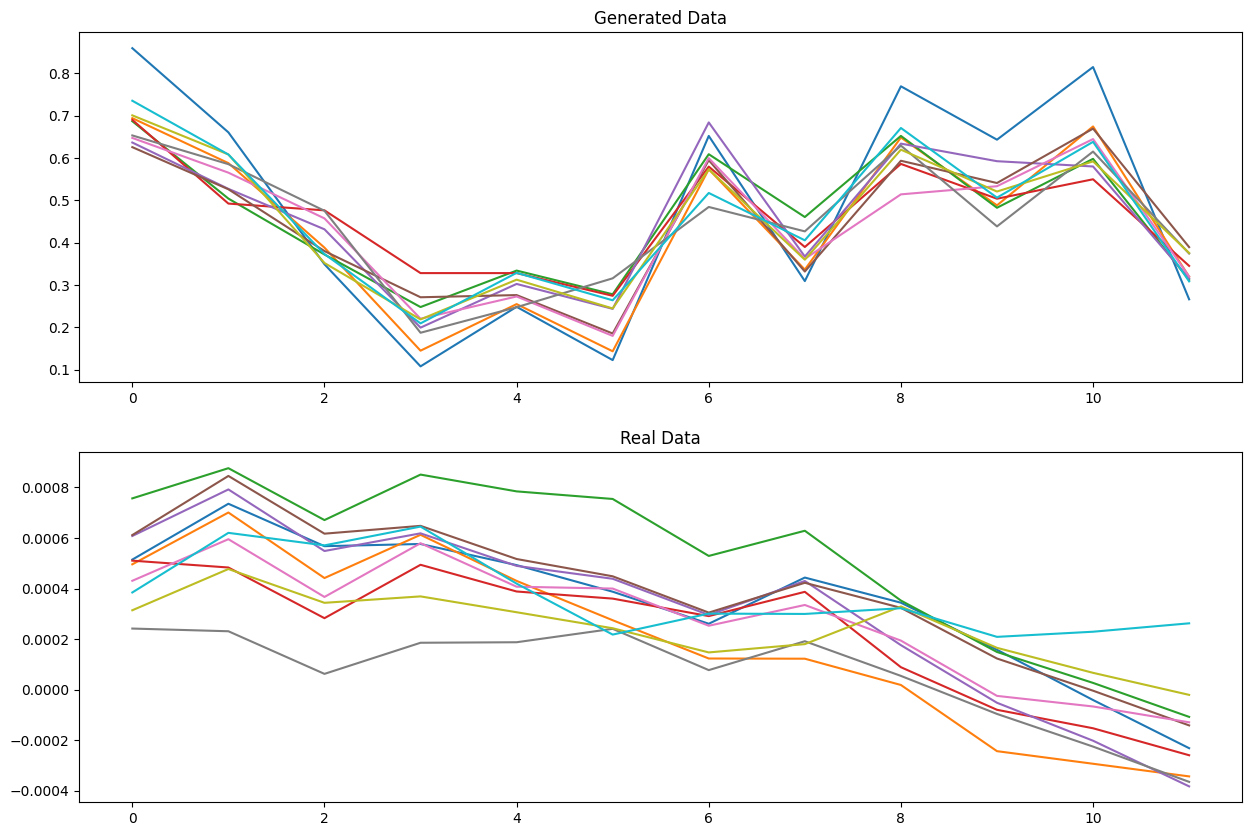

In [16]:
sample_list = []
for i in range(0, 100):
    with torch.no_grad():
        sample = ddpm.sample(1)
        sample = sample.cpu().numpy().squeeze()
    
    sample_list.append(sample)

sample_mean = np.mean(sample_list, axis=0)
gt_mean = test_data.mean(axis=0)

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for i in range(0, sample_mean.shape[0]):
    axs[0].plot(range(0, sample_mean.shape[1]), sample_mean[i])
    axs[1].plot(range(0, gt_mean.shape[1]), gt_mean[i])

axs[0].set_title("Generated Data")
axs[1].set_title("Real Data")


## With Conditioning

In [ ]:
with torch.no_grad():
    cond_samples_train = ddpm.sample(real_cond_data_train.shape[0], real_cond_data_train.to(device))
    cond_samples_train = cond_samples_train.cpu().numpy()

print(f"Samples shape: {cond_samples_train.shape}")

## Train

### T-SNE and PCA

In [ ]:
visual_evaluation(real_data_train, cond_samples_train, log_file_name, True, "train")

### Jensen-Shannon-Divergence

In [ ]:
plot_jsd(real_data_train, real_data_test, cond_samples_train.transpose(0,2,1), log_file_name, cond=True)

## Test

In [ ]:
with torch.no_grad():
    cond_samples_test = ddpm.sample(real_cond_data_test.shape[0], real_cond_data_test.to(device))
    cond_samples_test = cond_samples_test.cpu().numpy()

print(f"Samples shape: {cond_samples_test.shape}")

In [ ]:
visual_evaluation(real_data_test, cond_samples_test, log_file_name, True, "test")

### Jensen-Shannon Divergence

In [ ]:
plot_jsd(real_data_train, real_data_test, cond_samples_test.transpose(0,2,1), log_file_name, cond=True)

# Logging

In [ ]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\n\nRMSE Values:\n")
    for rmse in rmse_list:
        log_file.write(f"{rmse}\n")

print(f"Log file created at: {log_file_path}")

In [ ]:
#best_model = torch.load("./logging/weights/TransEncoder_te_2025-02-19-19-39/best_model_weights.pth")